In [1]:
%matplotlib inline

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import mlflow

# Road Segmentation

## Data Analysis

### EDA

In [33]:
def display_proportions(meta):
    train_portion = meta.groupby('split').size()['train']/len(meta)
    val_portion = meta.groupby('split').size()['val']/len(meta)
    test_portion = meta.groupby('split').size()['test']/len(meta)
    
    print(f'Train portion: {train_portion}')
    print(f'Validation portion: {val_portion}')
    print(f'Test portion: {test_portion}')

In [90]:
def reassign_split(meta, val_portion=0.1, test_portion = 0.1):
    meta.split = 'train'
    total_len = len(meta)
    test_start_idx = total_len - round(total_len * test_portion)
    val_start_idx = total_len - round(total_len * (test_portion + val_portion))
    
    
    meta.loc[test_start_idx:, 'split'] = 'test'
    meta.loc[val_start_idx:test_start_idx-1, 'split'] = 'val'
    
    return meta

### Massachusetts Roads Dataset (Draft)

In [ ]:
meta_mass = pd.read_csv('data/massroads/metadata.csv')
meta_mass = meta_mass.drop(['image_id', 'image_souce_url','label_source_url', 'png_image_path', 'png_label_path'], axis = 1).rename(columns={'tif_label_path':'tiff_label_path'})
meta_mass

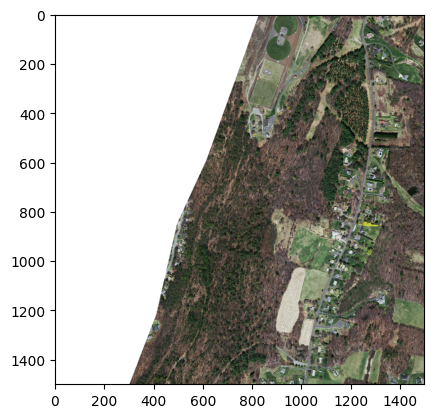

In [4]:
plt.imshow(plt.imread(f'data/massroads/{meta_mass.iloc[4].tiff_image_path}'))

In [5]:
test_image = plt.imread(f'data/massroads/{meta_mass.iloc[4].tiff_image_path}')

In [6]:
# Modified function from https://medium.com/@nithishmailme/satellite-imagery-road-segmentation-ad2964dc3812
def select_images_massroads(meta, thereshold):
    splits=[]
    complete_image_paths=[]
    mask_paths=[]
    for i in range(len(meta)):
        split = meta.iloc[i].split
        img_path = f'data/massroads/{meta.iloc[i].tiff_image_path}'
        msk_path = f'data/massroads/{meta.iloc[i].tiff_label_path}'
        image = cv2.imread(img_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
        if (np.sum(gray_image==255)/(2250000))<thereshold:
            splits.append(split)
            complete_image_paths.append(img_path)
            mask_paths.append(msk_path)

    df = pd.DataFrame(zip(splits, complete_image_paths, mask_paths))
    df.columns = ['split', 'image_path', 'label_path']
    return df

In [7]:
mass_meta_filtered = select_images_massroads(meta_mass, 0.1)

In [8]:
mass_meta_filtered

split                                  image_path  \
0    train  data/massroads/tiff/train/10078675_15.tiff   
1    train  data/massroads/tiff/train/10078690_15.tiff   
2    train  data/massroads/tiff/train/10078705_15.tiff   
3    train  data/massroads/tiff/train/10228675_15.tiff   
4    train  data/massroads/tiff/train/10228705_15.tiff   
..     ...                                         ...   
846   test   data/massroads/tiff/test/25079170_15.tiff   
847   test   data/massroads/tiff/test/26278720_15.tiff   
848   test   data/massroads/tiff/test/26428735_15.tiff   
849   test   data/massroads/tiff/test/26578720_15.tiff   
850   test   data/massroads/tiff/test/26878690_15.tiff   

                                           label_path  
0    data/massroads/tiff/train_labels/10078675_15.tif  
1    data/massroads/tiff/train_labels/10078690_15.tif  
2    data/massroads/tiff/train_labels/10078705_15.tif  
3    data/massroads/tiff/train_labels/10228675_15.tif  
4    data/massroads/tiff/train_labels/10228705_15.tif  
..                                                ...  
846   data/massroads/tiff/test_labels/25079170_15.tif  
847   data/massroads/tiff/test_labels/26278720_15.tif  
848   data/massroads/tiff/test_labels/26428735_15.tif  
849   data/massroads/tiff/test_labels/26578720_15.tif  
850   data/massroads/tiff/test_labels/26878690_15.tif  

[851 rows x 3 columns]

In [10]:
display_proportions(mass_meta_filtered)

Train portion: 0.9259694477085781
Validation portion: 0.01645123384253819
Test portion: 0.057579318448883664


In [ ]:
mass_meta_filtered = reassign_split(mass_meta_filtered)

In [12]:
display_proportions(mass_meta_filtered)

Train portion: 0.7978848413631022
Validation portion: 0.10105757931844889
Test portion: 0.10105757931844889


In [14]:
test_image = Image.open(f'data/massroads/{meta_mass.iloc[4].tiff_image_path}')
gray_test = test_image.convert('L')

In [13]:
def split_image(image, patch_size=512):
    if image.size != (1500, 1500):
        raise ValueError("Input image must be 1500x1500 pixels")
        
    # Define the top-left corner coordinates for each patch
    coordinates = [
        (0, 0), (494, 0), (988, 0),
        (0, 494), (494, 494), (988, 494),
        (0, 988), (494, 988), (988, 988)
    ]
    
    patches = [image.crop((x, y, x + patch_size, y + patch_size)) for x, y in coordinates]
    return patches

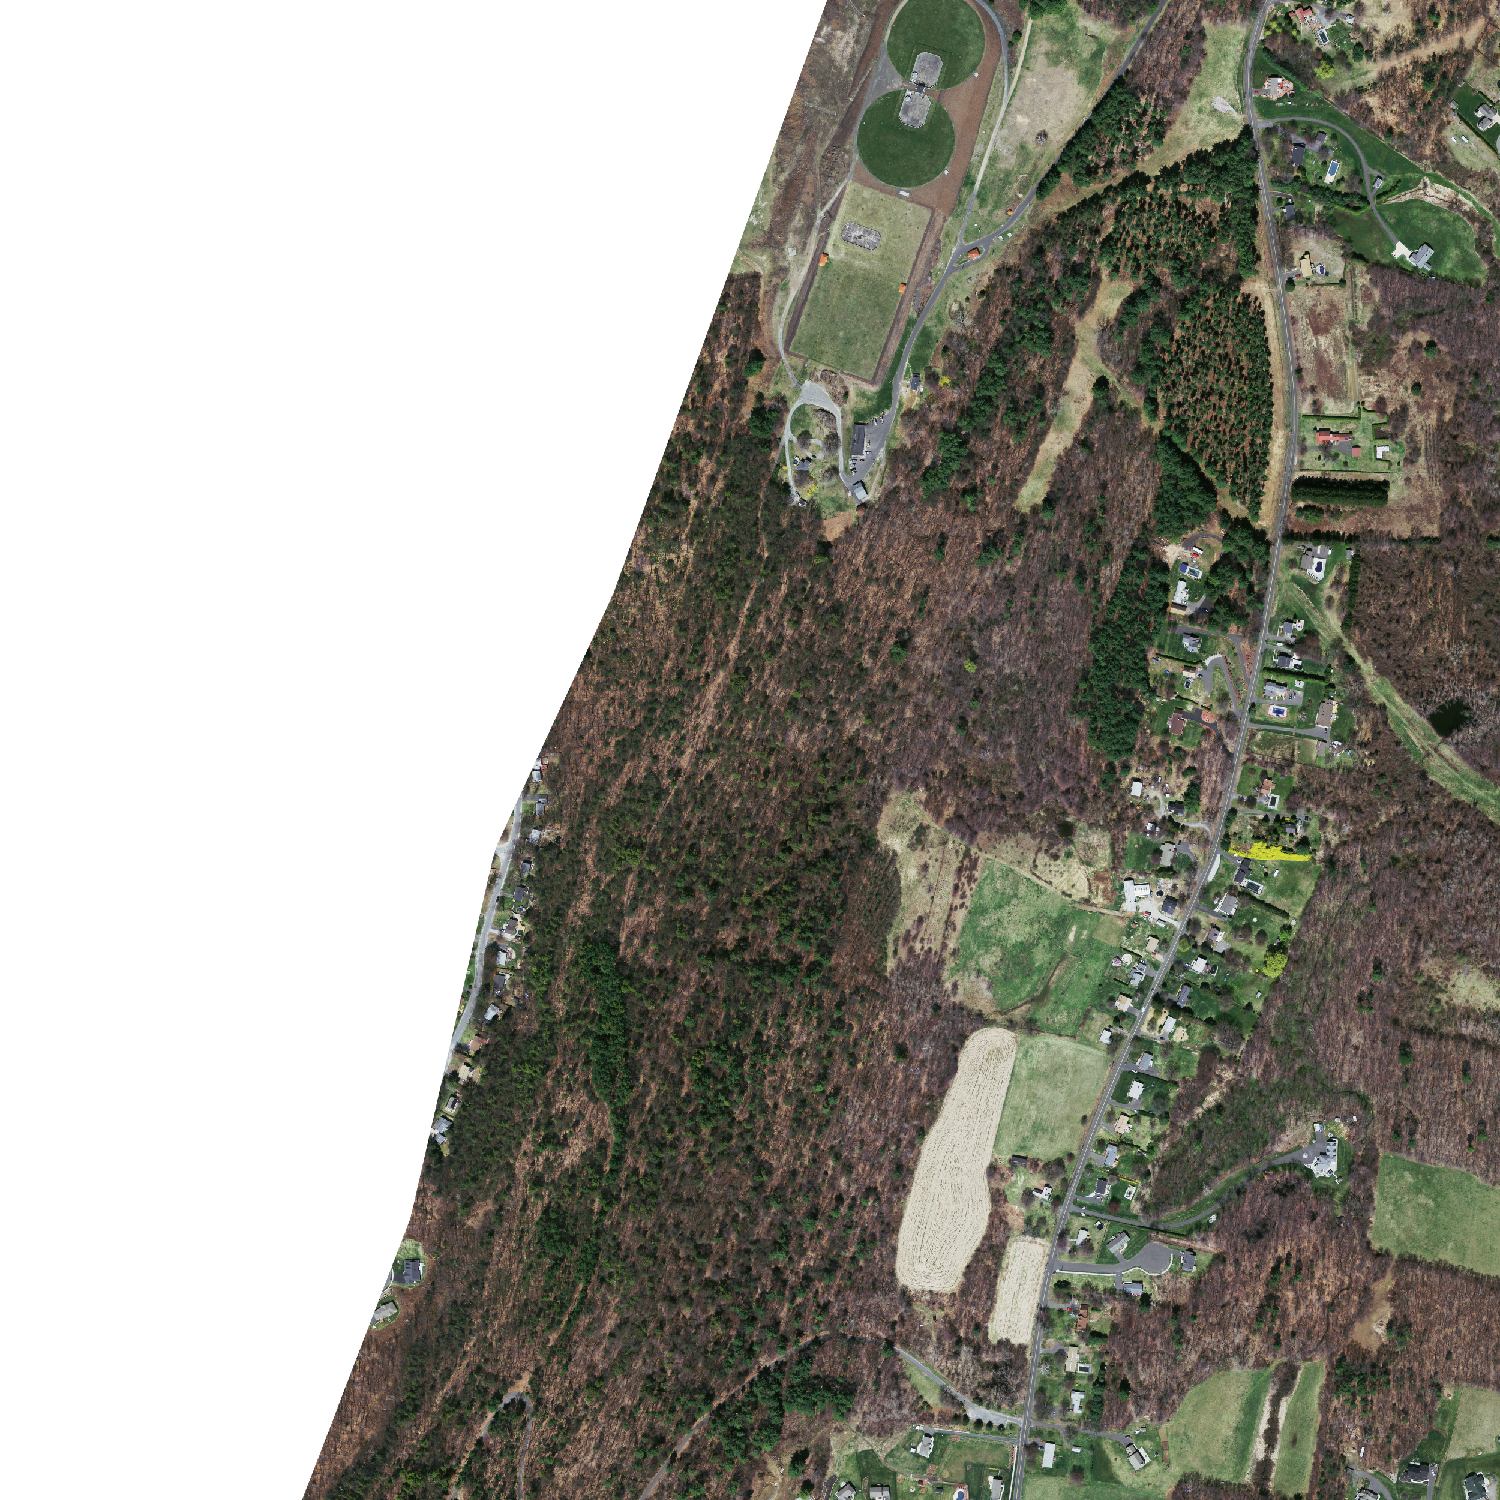

In [15]:
test_image

In [16]:
split_image(gray_test)

[<PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>,
 <PIL.Image.Image image mode=L size=512x512>]

### Deepglobe dataset

In [91]:
root_deep='data/deepglobe/'

In [92]:
deep_meta = pd.read_csv('data/deepglobe/metadata.csv')
deep_meta = deep_meta[deep_meta.split == 'train']
deep_meta = reassign_split(deep_meta)
deep_meta

image_id  split        sat_image_path              mask_path
0       100034  train  train/100034_sat.jpg  train/100034_mask.png
1       100081  train  train/100081_sat.jpg  train/100081_mask.png
2       100129  train  train/100129_sat.jpg  train/100129_mask.png
3       100703  train  train/100703_sat.jpg  train/100703_mask.png
4       100712  train  train/100712_sat.jpg  train/100712_mask.png
...        ...    ...                   ...                    ...
6221    999431   test  train/999431_sat.jpg  train/999431_mask.png
6222    999531   test  train/999531_sat.jpg  train/999531_mask.png
6223    999667   test  train/999667_sat.jpg  train/999667_mask.png
6224    999764   test  train/999764_sat.jpg  train/999764_mask.png
6225     99995   test   train/99995_sat.jpg   train/99995_mask.png

[6226 rows x 4 columns]

In [93]:
display_proportions(deep_meta)

Train portion: 0.8000321233536781
Validation portion: 0.09990362993896562
Test portion: 0.10006424670735625


In [97]:
image_test = Image.open(os.path.join(root_deep, deep_meta.iloc[15].sat_image_path))
mask_test = np.array(Image.open(os.path.join(root_deep, deep_meta.iloc[15].mask_path)).convert('L'))

In [98]:
np.unique(mask_test)

array([  0, 255], dtype=uint8)

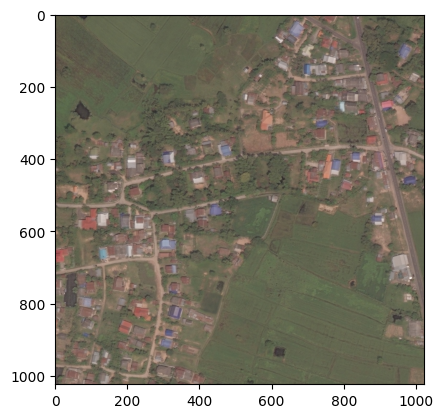

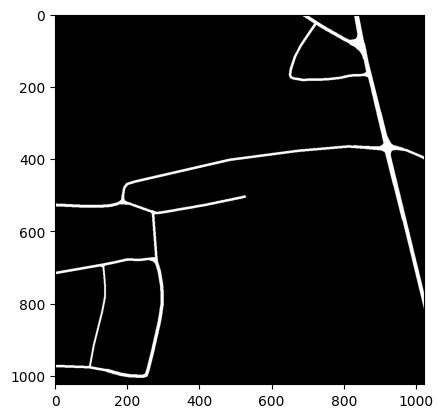

In [100]:
plt.imshow(image_test)
plt.show()
plt.imshow(mask_test, cmap='gray')
plt.show()

#### PyTorch Dataset

In [79]:
class DeepGlobeDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.root_dir = 'data/deepglobe/'
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        sat_image = Image.open(os.path.join(self.root_dir, self.metadata.iloc[idx].sat_image_path))
        mask = Image.open(os.path.join(self.root_dir, self.metadata.iloc[idx].mask_path)).convert('L')

        if self.transform:
            sat_image = self.transform(sat_image)
            mask = self.transform(mask)

        return sat_image, mask

image_transform = transforms.Compose([
    transforms.ToTensor()
])

In [80]:
train_metadata = deep_meta[deep_meta.split == 'train'].reset_index(drop=True)
val_metadata = deep_meta[deep_meta.split == 'val'].reset_index(drop=True)
test_metadata = deep_meta[deep_meta.split == 'test'].reset_index(drop=True)

train_ds = DeepGlobeDataset(train_metadata, transform=image_transform)
val_ds = DeepGlobeDataset(val_metadata, transform=image_transform)
test_ds = DeepGlobeDataset(test_metadata, transform=image_transform)

In [89]:
print(f'Image shape: {train_ds[0][0].shape}')
print(f'Mask shape: {train_ds[0][1].shape}')

Image shape: torch.Size([3, 1024, 1024])
Mask shape: torch.Size([1, 1024, 1024])
